<a href="https://colab.research.google.com/github/jaco-uoeo/ml-artefact/blob/main/team_project/UoEO_ML_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1 (Business analytic question)
Propose an interesting business analytic question that can be answered using the given Airbnb dataset. The proposed question should be useful for Airbnb. An example question could be: is there any noticeable difference in bookings among different areas and what could be the reasons for it?

Data source location:  [New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

Data Dictionary: [Inside Airbnb](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?pli=1&gid=1322284596#gid=1322284596)

## Understand our customers

- Are there specific price range brackets that attract customers more than others?
- Do location have an impact on pricing?
- Can proximity to high-value location infuence pricing?

- **Can we price un-reviewed hosts based on proximity to reviewed hosts?**  


# TASK 2 (Data analysis)
In this task, use your data analytics skills to answer the question posed in the Task 1. Depending upon your chosen question, you will typically have to perform Exploratory Data Analysis (EDA), data pre-processing, statistics-based data analysis, data visualisation and use unsupervised machine learning algorithms (e.g., clustering).

## 2.1 Setup and Initialization

In [ ]:
# @title Dependencies

import os
import math
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# set our styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style('darkgrid')

In [ ]:
# @title Load Dataset

path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")
csv_file = os.path.join(path, "AB_NYC_2019.csv")

# import the data and specify an encoding to get notified if any columns are in an unexpected format that panadas cannot work with
# we'll also ensure that pandas convert the 'last_review' to a datetime to more accurately match the intended datatype
df = pd.read_csv(
    csv_file,
    encoding="ISO-8859-1",
    parse_dates=["last_review"]
  )

100%|██████████| 2.44M/2.44M [00:00<00:00, 118MB/s]

Extracting files...


## 2.2 Basic Overview and Missing Values

In [ ]:
# @title Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

In [ ]:
# @title Descriptive
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,2018-10-04 01:47:23.910099456,1.373221,7.143982,112.781327
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,2011-03-28 00:00:00,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,2018-07-08 00:00:00,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,2019-05-19 00:00:00,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2019-06-23 00:00:00,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,NaN,1.680442,32.952519,131.622289


In [ ]:
# @title Add some utility columns
df['last_review_month'] = pd.to_datetime(df['last_review'], errors='coerce').dt.month

In [ ]:
# @title Missing Values
df.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [ ]:
# @title Missing Value Replacements

# the missing data is limited to venue name, host name, and the two review columns last_review and reviews_per month
# last_review and reviews_per_month are related and the data shows the same number of missing values -
# this may indicate that the property has never been reviewed

# we'll cleanup the name and host name with a label
df['name'] = df['name'].fillna('Unknown')
df['host_name'] = df['host_name'].fillna('Unknown')

# we'll do the same for the missing reviews, we'll leave the last review as NaT but
# ensure reviews_per_month is zero in these cases
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

df.isnull().sum()

,0
id,0
name,0
host_id,0
host_name,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


## 2.3 Data Distribution in Original Dataset

Text(0.5, 1.0, 'Price Frequency Distribution')

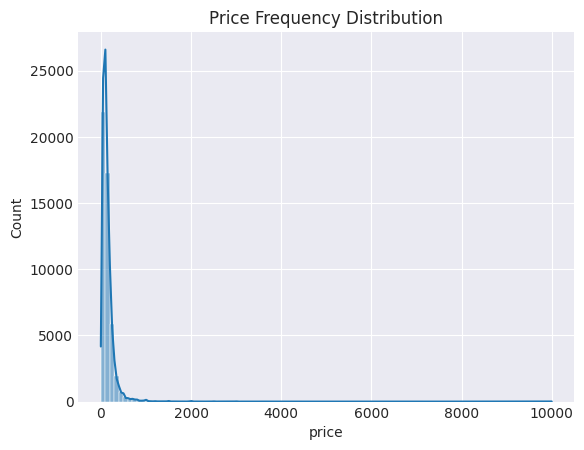

In [ ]:
# @title Frequency distributions

sns.histplot(data=df, x='price', bins=100, kde=True).set_title('Price Frequency Distribution')

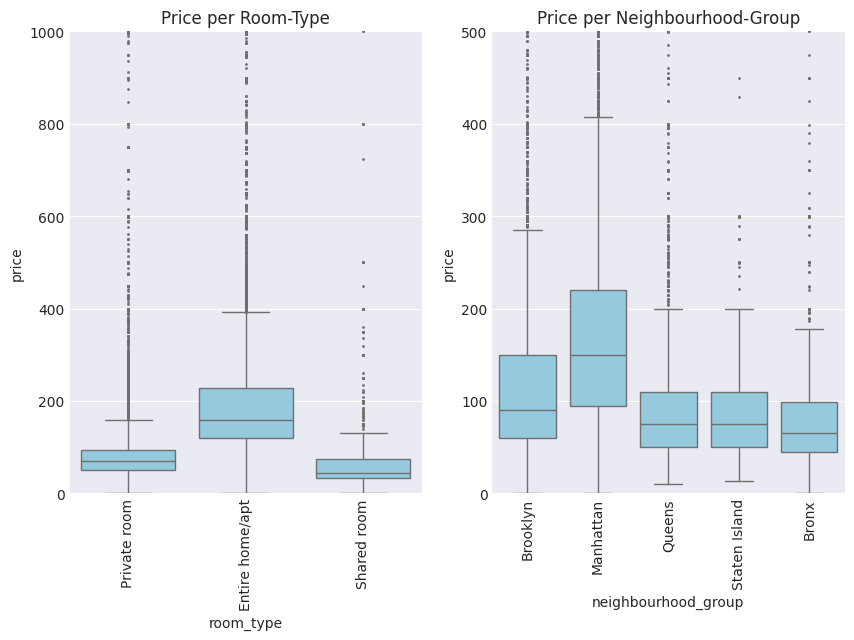

In [ ]:
# @title Price distributions

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

rt = sns.boxplot(data=df, x='room_type', y='price', ax=axes[0,], fliersize=1, color='skyblue')
rt.set_title('Price per Room-Type')
rt.set_ylim([0, 1000])
rt.tick_params("x",labelrotation=90)

ng = sns.boxplot(data=df, x='neighbourhood_group', y='price', ax=axes[1,], fliersize=1, color='skyblue')
ng.set_title('Price per Neighbourhood-Group')
ng.set_ylim([0, 500])
ng.tick_params("x",labelrotation=90)

## 2.4 Handling Outliers

In [ ]:
# @title Handle rows with invalid price values
# It seems that the minimum listing proces on AirBnB is $10 so lets check the impact we'll remove all values smaller than
# Source: https://community.withairbnb.com/t5/Help-with-your-business/AirBnb-are-making-me-charge-at-least-10-quot-Your-minimum-price/td-p/171070

print("Before removal: ", df[df.price < 10].shape[0])

# there's only 28 rows that have zero proces, we'll remove them now as they are obviously incorrect
df = df[df.price >= 10]

print("After removal: ", df[df.price < 10].shape[0])

Before removal:  11
After removal:  0


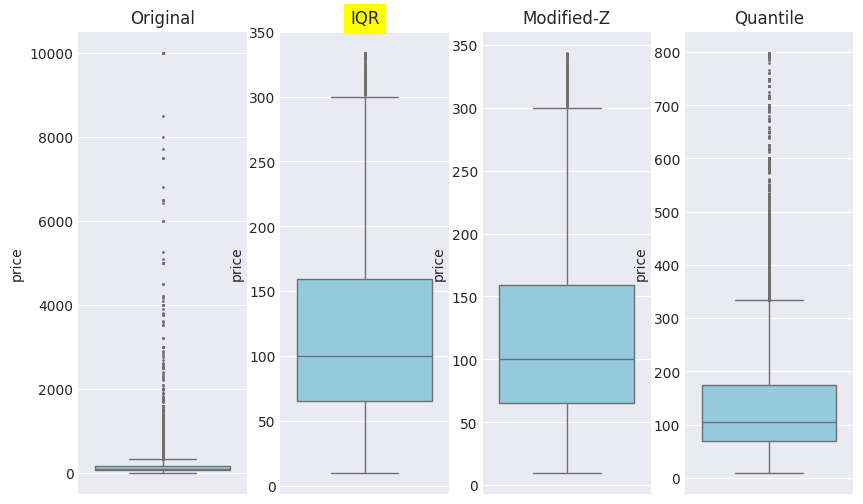

In [ ]:
# @title Select an outlier detection method and apply it
# Sources: https://etheses.dur.ac.uk/2432/1/2432_443.pdf
# Sources: https://towardsdatascience.com/outlier-detection-part1-821d714524c/

# IQR method for outlier detection
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df_iqr = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# modified z-score method for outlier detection
median = df['price'].median()
# calculate the median of the absolute deviations from the median
mad = np.median(np.abs(df['price'] - median))

modified_z_scores = 0.6745 * (df['price'] - median) / mad

# define a threshold
threshold = 3.5
df_mzs = df[modified_z_scores.abs() < threshold]

# simple quantile method
df_sqm = df[(df['price'] > 0) & (df['price'] <= df['price'].quantile(0.99))]

fig, axes = plt.subplots(1, 4, figsize=(10, 6), sharey=False)

bp_orig = sns.boxplot(data=df, y='price', ax=axes[0,], fliersize=1, color='skyblue').set_title('Original')
bp_iqr = sns.boxplot(data=df_iqr, y='price', ax=axes[1,], fliersize=1, color='skyblue').set_title('IQR')
bp_mzs = sns.boxplot(data=df_mzs, y='price', ax=axes[2,], fliersize=1, color='skyblue').set_title('Modified-Z')
bp_sqm = sns.boxplot(data=df_sqm, y='price', ax=axes[3,], fliersize=1, color='skyblue').set_title('Quantile')

# CHOICE: we choose the dataset without outliers here
df_clean = df_iqr.copy()
bp_iqr.set_backgroundcolor('yellow')


In [ ]:
# @title Observation Counts
before = df['id'].count()
after = df_clean['id'].count()
diff = before - after

print("Original: ", before)
print("Cleaned:  ", after)
print("Removed:  ", diff, f'({(diff/before*100):.2f}%)')

Original:  48884
Cleaned:   45912
Removed:   2972 (6.08%)


### Price Frequency Distribution Before and After Outlier Removal

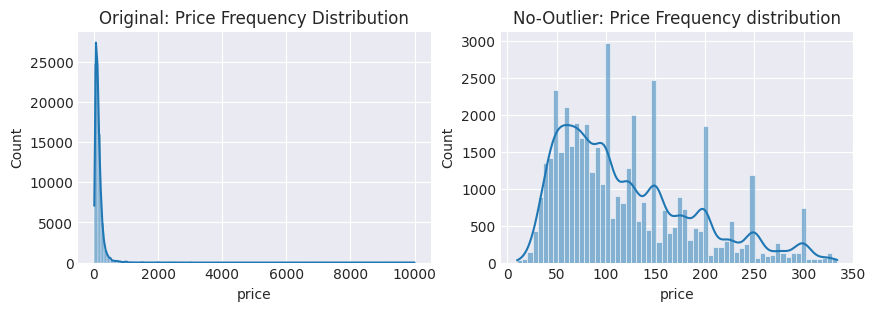

**Observations:**

Frequency distribution is still right-sided, however, no longer have as affected by outliers as before.

### Room Type and Neighbourhood Group Frequency distributions Before and After Outlier Removal

<Axes: xlabel='neighbourhood_group'>

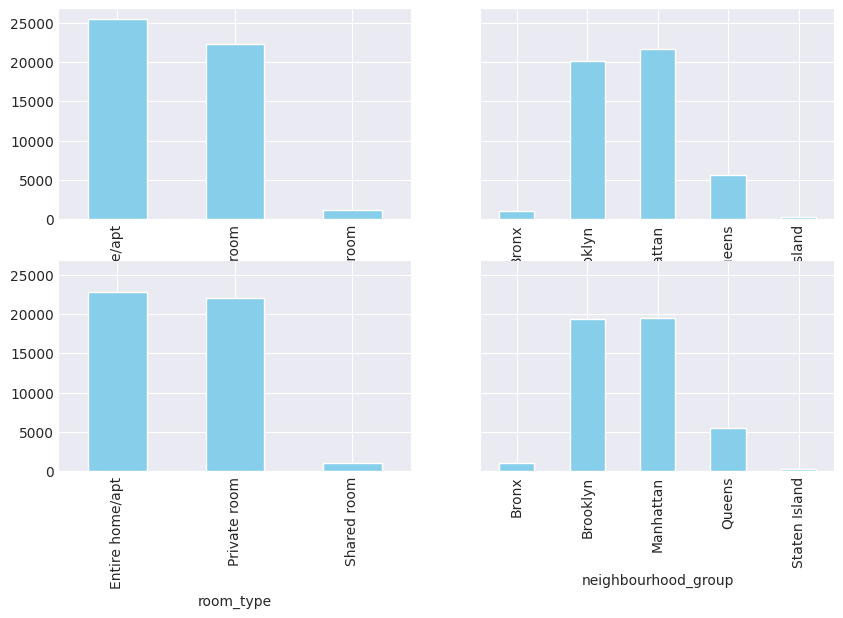

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)

df.groupby('room_type').size().plot(kind='bar', ax=axes[0,0], color='skyblue')
df.groupby('neighbourhood_group').size().plot(kind='bar', ax=axes[0,1], color='skyblue')

df_clean.groupby('room_type').size().plot(kind='bar', ax=axes[1,0], color='skyblue')
df_clean.groupby('neighbourhood_group').size().plot(kind='bar', ax=axes[1,1], color='skyblue')

**Observations:**

- In both cases the general distribution remained relatively the same, however, Brooklyn and Manhattan's frequency have gotten closer.
- Many of the outliers must have been located in Manhattan.


### Price distributions before and after Outlier Removal

Text(0, 0.5, '')

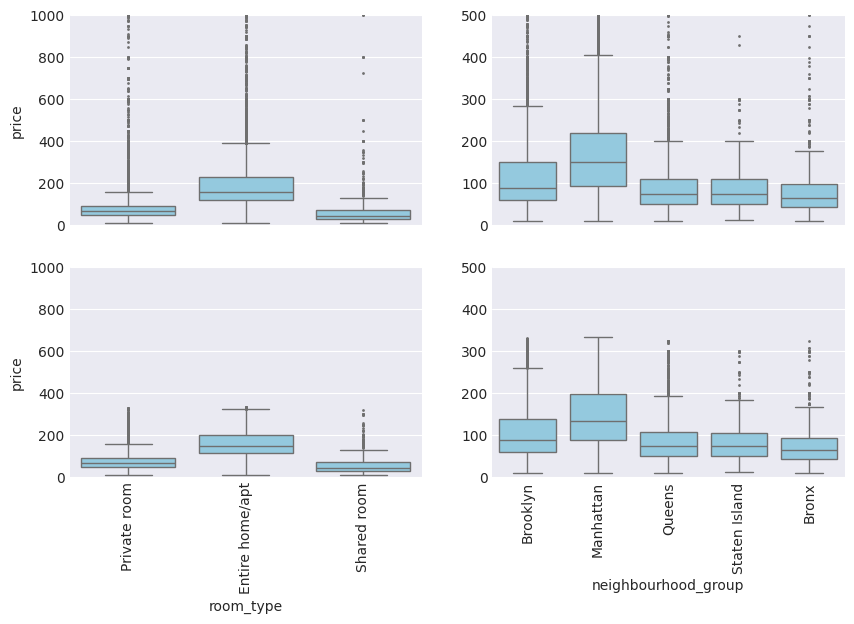

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
#plt.subplots_adjust(wspace=0.3, hspace=0.3)

# -- Original dataset

rt = sns.boxplot(data=df, x='room_type', y='price', ax=axes[0,0], fliersize=1, color='skyblue')
rt.set_ylim([0, 1000])
axes[0,0].set_xticks([])
axes[0,0].set_xticklabels([])
axes[0,0].set_xlabel('')

ng = sns.boxplot(data=df, x='neighbourhood_group', y='price', ax=axes[0,1], fliersize=1, color='skyblue')
ng.set_ylim([0, 500])
axes[0,1].set_xticks([])
axes[0,1].set_xticklabels([])
axes[0,1].set_ylabel('')
axes[0,1].set_xlabel('')

# -- Dataset with outliers removed

rt2 = sns.boxplot(data=df_clean, x='room_type', y='price', ax=axes[1,0], fliersize=1, color='skyblue')
rt2.set_ylim([0, 1000])
rt2.tick_params("x",labelrotation=90)

ng2 = sns.boxplot(data=df_clean, x='neighbourhood_group', y='price', ax=axes[1,1], fliersize=1, color='skyblue')
ng2.set_ylim([0, 500])
ng2.tick_params("x",labelrotation=90)
axes[1,1].set_ylabel('')

**Observations:**

Outlier removal did not have an appreciable effect on the price distributions.

### Mean price at review across the months of the year

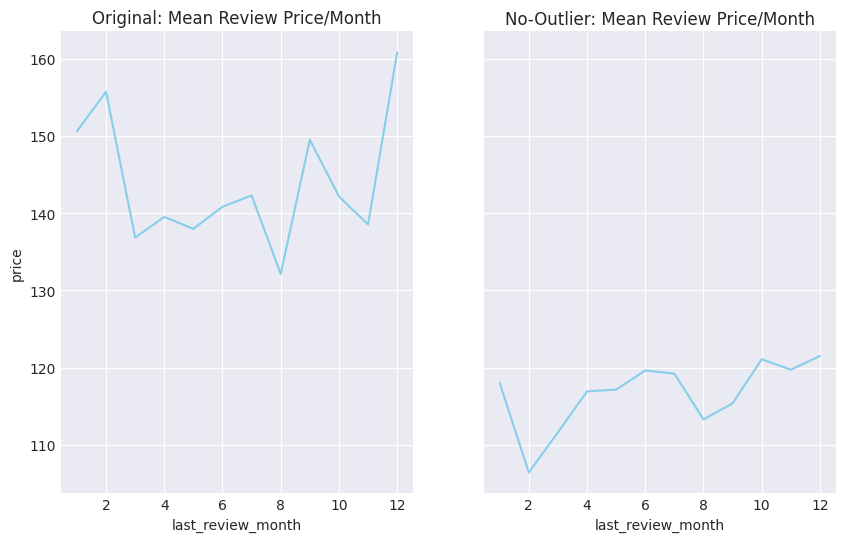

In [ ]:
#df.groupby('last_review_month')['price'].mean().plot(kind='line')

df1 = df.groupby('last_review_month')['price'].mean()
df2 = df_clean.groupby('last_review_month')['price'].mean()

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

sns.lineplot(data=df1, ax=axes[0,], color='skyblue').set_title('Original: Mean Review Price/Month')
sns.lineplot(data=df2, ax=axes[1,], color='skyblue').set_title('No-Outlier: Mean Review Price/Month')

# remove labels
plt.gca().spines[['top', 'right',]].set_visible(False)


**Observations:**

Outliers has a significant impact on the mean review price per month, hilighting the importance of not using means as a measure in highly skewed datasets.

### Number of review across the months of the year

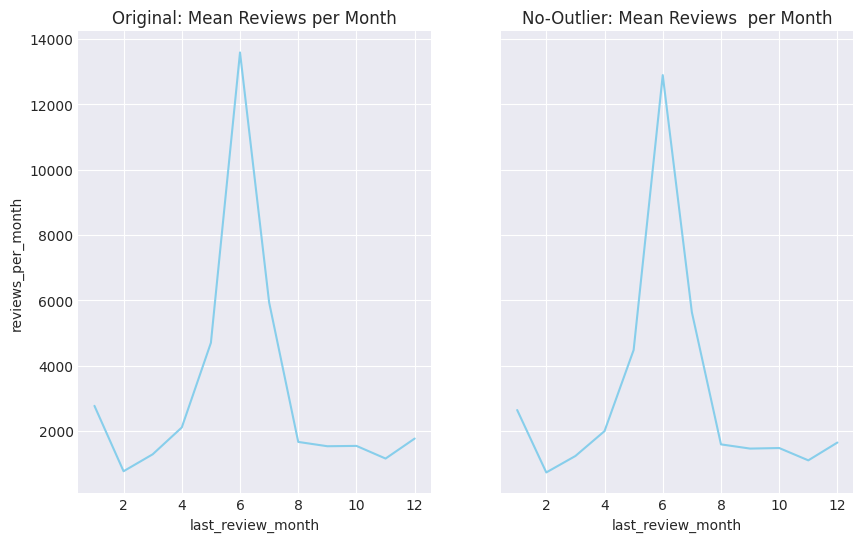

In [ ]:

df1 = df.groupby('last_review_month')['reviews_per_month'].size()
df2 = df_clean.groupby('last_review_month')['reviews_per_month'].size()

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)

sns.lineplot(data=df1, ax=axes[0,], color='skyblue').set_title('Original: Mean Reviews per Month')
sns.lineplot(data=df2, ax=axes[1,], color='skyblue').set_title('No-Outlier: Mean Reviews  per Month')

# remove labels
plt.gca().spines[['top', 'right',]].set_visible(False)

**Observations:**

- Outliers had no signifiocant impact on review per month frequencies.
- Most reviews are made in July, perhaps indicating a 'busy' season preceded it.

**Insights:**

- There is potential for growth in rentals in other months.
- A pricing strategy can be investigated to increase rentals is off-seasons, given the significant variance between a single month vs. the rest of the year.


## 2.5 Further Analysis on Cleaned data

### Price Distribution with Mean, Median, Min, Max, Q1, and Q3

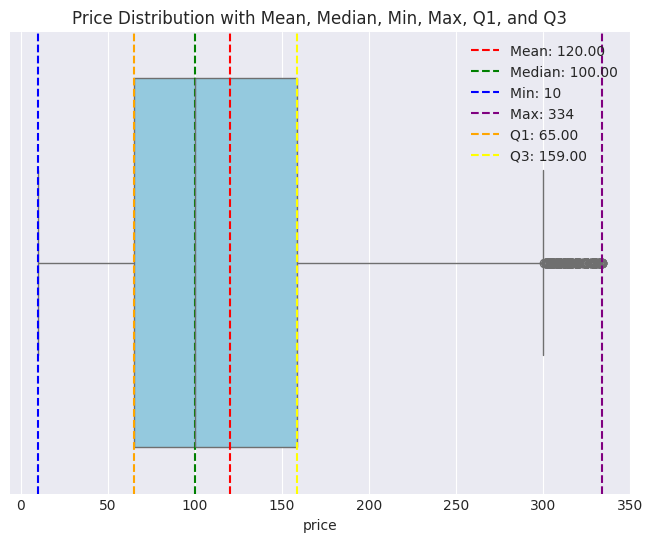

In [ ]:
mean = df_clean['price'].mean()
median = df_clean['price'].median()
min_val = df_clean['price'].min()
max_val = df_clean['price'].max()
q1 = df_clean['price'].quantile(0.25)
q3 = df_clean['price'].quantile(0.75)

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_clean['price'], color='skyblue')

# add lines for mean, median, min, max, Q1, and Q3
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', label=f'Median: {median:.2f}')
plt.axvline(min_val, color='blue', linestyle='--', label=f'Min: {min_val}')
plt.axvline(max_val, color='purple', linestyle='--', label=f'Max: {max_val}')
plt.axvline(q1, color='orange', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(q3, color='yellow', linestyle='--', label=f'Q3: {q3:.2f}')

plt.title('Price Distribution with Mean, Median, Min, Max, Q1, and Q3')
plt.legend()

**Observations:**

- The mean is greater than the median, indicating that the distribution is still right-skewed with some high-price outliers that are pushing the mean up.
The interquartile range (IQR) of 94 shows that the central 50% of prices lie within a $94 IQR range.
- There are some high-value outliers that are affecting the mean, while the median provides a better indication of the "typical" price.

### Number of listings per Neighbourhood Group

neighbourhood_group
Manhattan        19505
Brooklyn         19406
Queens            5567
Bronx             1069
Staten Island      365
Name: count, dtype: int64


<Axes: xlabel='neighbourhood_group', ylabel='count'>

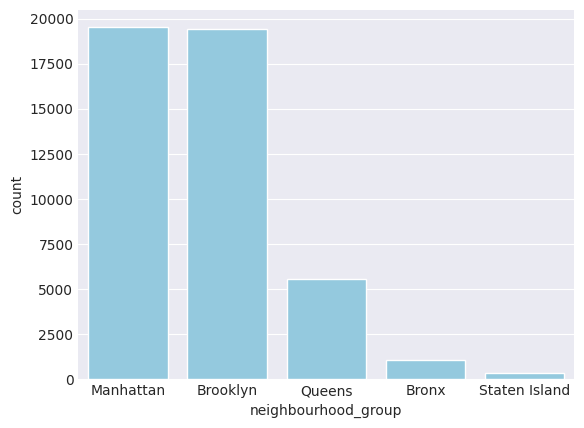

In [ ]:
listings_by_neighbourhood_group = df_clean['neighbourhood_group'].value_counts()
print(listings_by_neighbourhood_group)

dist_rt_per_ng = df_clean.groupby(['neighbourhood_group', 'room_type']).size().unstack()
sns.barplot(data=listings_by_neighbourhood_group, color="skyblue")

**Observations:**
- Brooklyn and Manhattan have the highest number of listsings by a large margin.
- While Queens is ranked third, is still significantly lower than the Big-2

**Insights:**
- The lower listings listings in Queens, the Bronx and Staten island indidate there's potential for growth in these areas.
- The higher density in Manhattan and Brooklyn may indicate that these areas could demand even higher prices and that the other three may need to be priced lower, or that more effort need to be put into marketing these areas.

### Average price per Neighbourhood Group

neighbourhood_group
Manhattan        145.960318
Brooklyn         105.748634
Staten Island     89.235616
Queens            88.904437
Bronx             77.437792
Name: price, dtype: float64


<Axes: xlabel='neighbourhood_group', ylabel='price'>

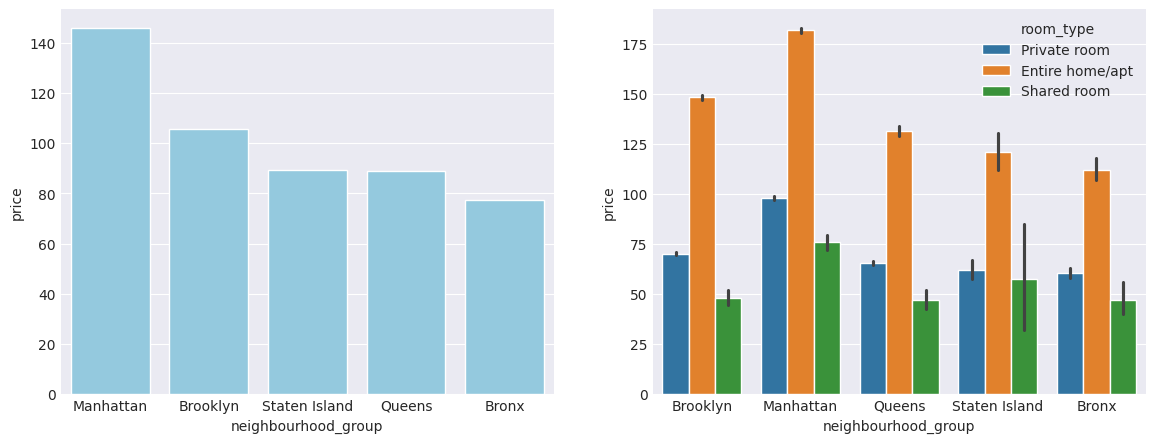

In [ ]:
avg_price_per_neighbourhood_group = df_clean.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
print(avg_price_per_neighbourhood_group)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False, sharey=False)

sns.barplot(data=avg_price_per_neighbourhood_group, color="skyblue", ax=axes[0,])
sns.barplot(data=df_clean, x='neighbourhood_group', y='price', hue='room_type', ax=axes[1,])


**Observations:**
- Manhattan commands the highest prices and is in line with earlier findings on listing count.
- Brooklyn, while prices secind highest is significantly closer in price than anticipated.  

**Insights:**
- With the lower three; Staten Island, Queens and the Bronx' prices being so close to Brooklyn, this is perhaps an indication that these areas would benefit greatly from more listings given clients are willing to pay these rates.
- There is a bit more variance in the pricing of Staten Island listings that may turn off some visitors if the first listing they view is the highest.  


### Price Distribution

room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                            363           647           59
Brooklyn                        8941         10056          409
Manhattan                      11293          7747          465
Queens                          2022          3351          194
Staten Island                    168           188            9 



Text(0.5, 1.0, 'Price Distribution per Neighbourhood Group')

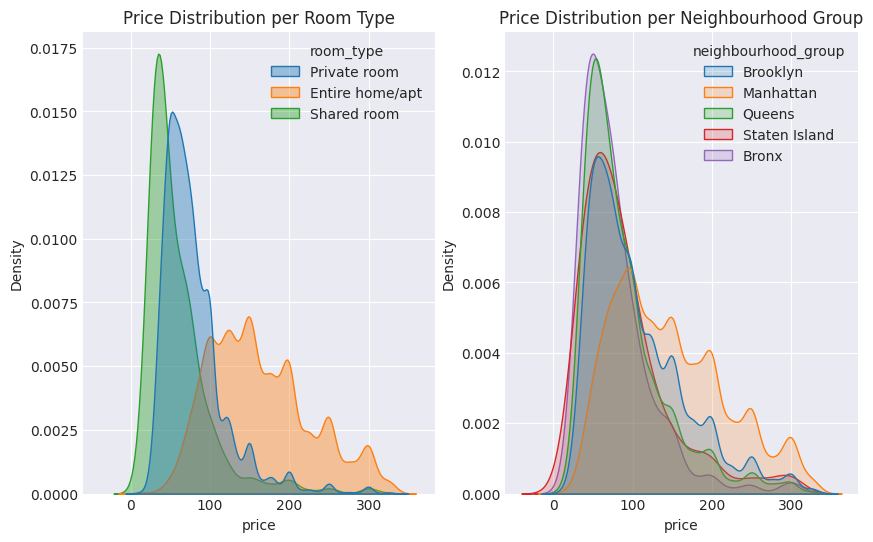

In [ ]:
dist_rt_per_ng = df_clean.groupby(['neighbourhood_group', 'room_type']).size().unstack()
print(dist_rt_per_ng, "\n")


fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=False)

sns.kdeplot(data=df_clean, x='price', hue="room_type", fill=True, common_norm=False, alpha=0.4, ax=axes[0,] ).set_title("Price Distribution per Room Type")
sns.kdeplot(data=df_clean, x='price', hue="neighbourhood_group", fill=True, common_norm=False, alpha=0.2, ax=axes[1,] ).set_title("Price Distribution per Neighbourhood Group")

**Observations:**
- Shared rooms occupy the lowes pricing levels and private rooms and entire home/apt's the higer pricing tiers.

**Insights:**
- Manhattan has the most listing for entire home/apt and is also commanding the highest price per listing, thereby pushing up it's relative income relative to the other groups.
- An emphasis could be places to increase listings in other neighbourhood groups for entire homes/apt to capitalize on the trend that this type of accomodation is more easily rented out.




### Relationship between Price and the number of reviews per Room Type

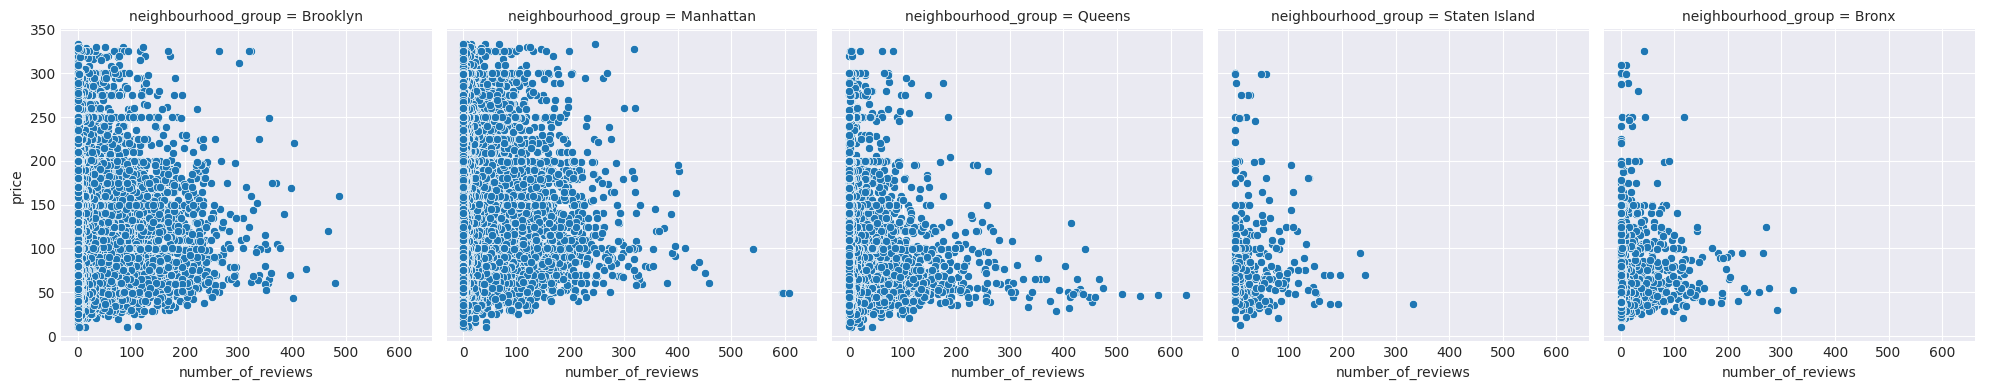

In [ ]:
g = sns.FacetGrid(df_clean, col="neighbourhood_group", height=4)
g.map(sns.scatterplot, 'number_of_reviews', 'price')
g.add_legend()

### Host Analysis: Listing Count per Neighbourhood Group

In [ ]:
number_of_hosts = df_clean['host_id'].nunique()

# get the listing count per host and distinguish between those with a single
# listing and those with more than one
listing_counts = df_clean.groupby(['host_id', 'host_name','neighbourhood_group'])['calculated_host_listings_count'].max()
multi_host = listing_counts[listing_counts > 1]

# get the top ten hosts and their number of listings
top_20_hosts = listing_counts.sort_values(ascending=False).head(100)

print("Total number of hosts in dataset: ", number_of_hosts)
print("Hosts with more than a single listing: ", multi_host.count())

print(top_20_hosts.tail())

#print("\n", top_20_hosts)

Total number of hosts in dataset:  35387
Hosts with more than a single listing:  5188
host_id    host_name      neighbourhood_group
10457196   Richard        Brooklyn               11
220229838  Chamber Hotel  Manhattan              11
173685298  Janet          Manhattan              11
10457196   Richard        Manhattan              11
229147376  Melly          Brooklyn               11
Name: calculated_host_listings_count, dtype: int64


**Observations:**
- There are 5188 hosts that host more multiple properties on Airbnb, with many hosting in the double and/or triple digits.
- Most of these are located in Manhatten and Brooklyn and Queens a distant third.

**Insights:**
-

### Host Analysis: Listing Count per Neighbourhood Group

In [ ]:
number_of_hosts = df_clean['host_id'].nunique()

# get the listing count per host and distinguish between those with a single
# listing and those with more than one
listing_counts = df_clean.groupby(['host_id', 'host_name','neighbourhood_group'])['calculated_host_listings_count'].max()
multi_host = listing_counts[listing_counts > 1]

# get the top ten hosts and their number of listings
top_20_hosts = listing_counts.sort_values(ascending=False).head(20)

print("Total number of hosts in dataset: ", number_of_hosts)
print("Hosts with more than a single listing: ", multi_host.count())

print("\n", top_20_hosts)

Total number of hosts in dataset:  35387
Hosts with more than a single listing:  5188

 host_id    host_name          neighbourhood_group
219517861  Sonder (NYC)       Manhattan              327
107434423  Blueground         Brooklyn               232
                              Manhattan              232
30283594   Kara               Manhattan              121
137358866  Kazuya             Queens                 103
                              Brooklyn               103
                              Manhattan              103
12243051   Sonder             Manhattan               96
16098958   Jeremy & Laura     Manhattan               96
61391963   Corporate Housing  Manhattan               91
22541573   Ken                Manhattan               87
                              Brooklyn                87
200380610  Pranjal            Manhattan               65
1475015    Mike               Manhattan               52
7503643    Vida               Brooklyn                52
1207624

### Correlation Heatmap

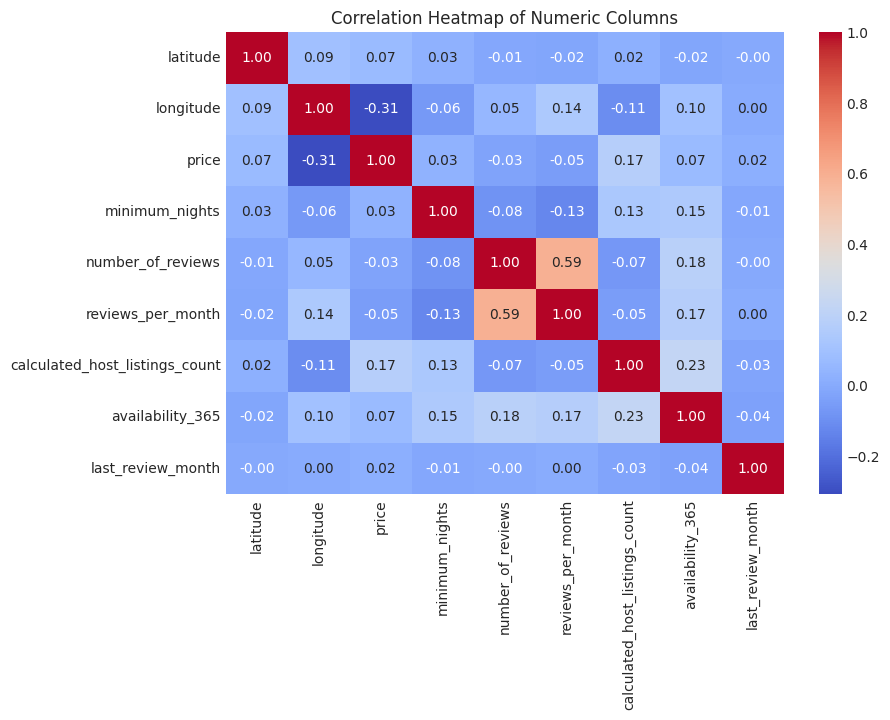

In [ ]:
cols = df_clean.drop(columns=['id','host_id']).select_dtypes(include=['int', 'float']).columns

plt.figure(figsize=[9,6])
sns.heatmap(df_clean[cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

**Observations:**

- The correlation beteen number of reviews and reviews per month is expected given the latter is derived from the first.
- There is a correlation between longitude and price. Something we can explore using an unsupervised learning technique.

## 2.6 Missing review analysis

### Missing Reviews: Basic statistics

In [ ]:
print("\nMissing values in 'last_review':")
missing_last_review = df_clean['last_review'].isnull().sum()
print(f"Number of missing 'last_review': {missing_last_review}")
print(f"Percentage of missing 'last_review': {missing_last_review / len(df) * 100:.2f}%")


Missing values in 'last_review':
Number of missing 'last_review': 9011
Percentage of missing 'last_review': 18.43%


### Missing by neighbourhood and neighbourhood group

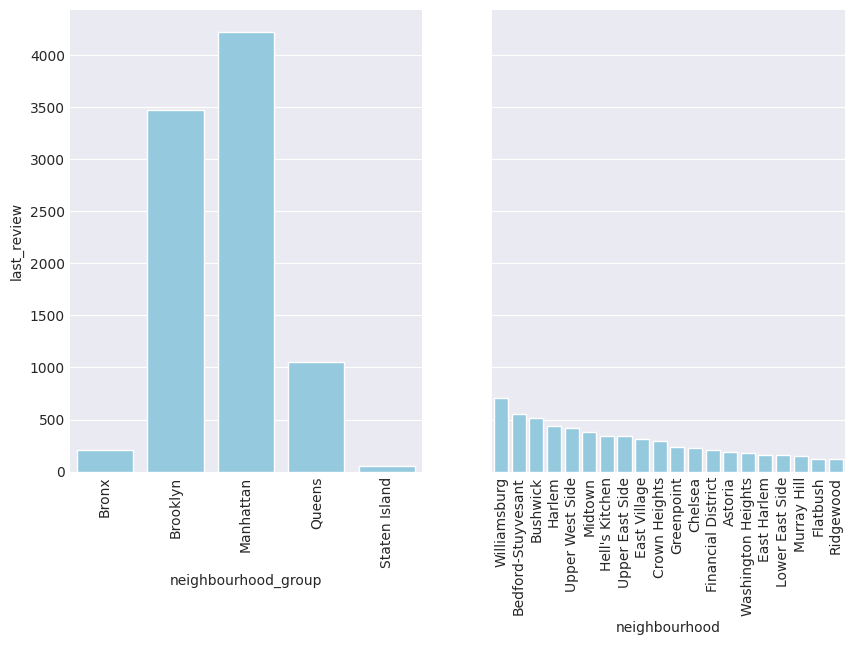

In [ ]:
missing_by_ng = df_clean.groupby('neighbourhood_group')['last_review'].apply(lambda x: x.isnull().sum())
missing_by_nb = df_clean.groupby('neighbourhood')['last_review'].apply(lambda x: x.isnull().sum()).sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

plt1 = sns.barplot(data=missing_by_ng, color="skyblue", ax=axes[0,])
plt2 = plt_by_nb = sns.barplot(data=missing_by_nb, color="skyblue", ax=axes[1,])

plt1.tick_params("x",labelrotation=90)
plt2.tick_params("x",labelrotation=90)

In [ ]:
print("\nNon-missing 'last_review_month' summary statistics:")
print(df_clean[df_clean['last_review_month'].notnull()]['last_review_month'].describe())

print("\nTime range of non-missing 'last_review':")
df_clean['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')  # Convert to datetime
print(df_clean[df_clean['last_review_month'].notnull()]['last_review_month'].min())
print(df_clean[df_clean['last_review_month'].notnull()]['last_review_month'].max())


Non-missing 'last_review_month' summary statistics:
count    36901.000000
mean         6.168180
std          2.529524
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         12.000000
Name: last_review_month, dtype: float64

Time range of non-missing 'last_review':
1.0
12.0


## 2.7 ML Techniques

### Price prediction for un-reviewed hosts

#### Setup our datasets

In [ ]:
# first, lets encode our categorical values, since these values are nominal categories we'll use one-hot encoding to avoid implying order
df_encoded = pd.get_dummies(df_clean, columns=['neighbourhood', 'neighbourhood_group', 'room_type'], drop_first=True)

# our training data will be data where we have reviews, and we'll predict on those without reviews
df_training = df_encoded[df_encoded.number_of_reviews > 0]
df_predict = df_encoded[df_encoded.number_of_reviews == 0]

# since we want to predict values only for those rows without rating, we ca can have a larger training size
# QUESTION: Should we include the outliers into the 'rediction' dataset too - could be interesting...
print("Training data size: ", df_training.shape[0])
print("Prediction data size: ", df_predict.shape[0])

Training data size:  36901
Prediction data size:  9011


#### Determine Feature Importance

                              Feature  Importance
230            room_type_Private room    0.338667
2                           longitude    0.141906
1                            latitude    0.117424
0                             host_id    0.072247
7                    availability_365    0.064154
5                   reviews_per_month    0.057864
231             room_type_Shared room    0.053212
4                   number_of_reviews    0.044501
3                      minimum_nights    0.036233
6      calculated_host_listings_count    0.021120
227     neighbourhood_group_Manhattan    0.010193
220        neighbourhood_Williamsburg    0.005001
133             neighbourhood_Midtown    0.001904
207     neighbourhood_Upper East Side    0.001349
20   neighbourhood_Bedford-Stuyvesant    0.001347
71         neighbourhood_East Village    0.000975
101      neighbourhood_Hell's Kitchen    0.000913
41              neighbourhood_Chelsea    0.000904
58        neighbourhood_Crown Heights    0.000726


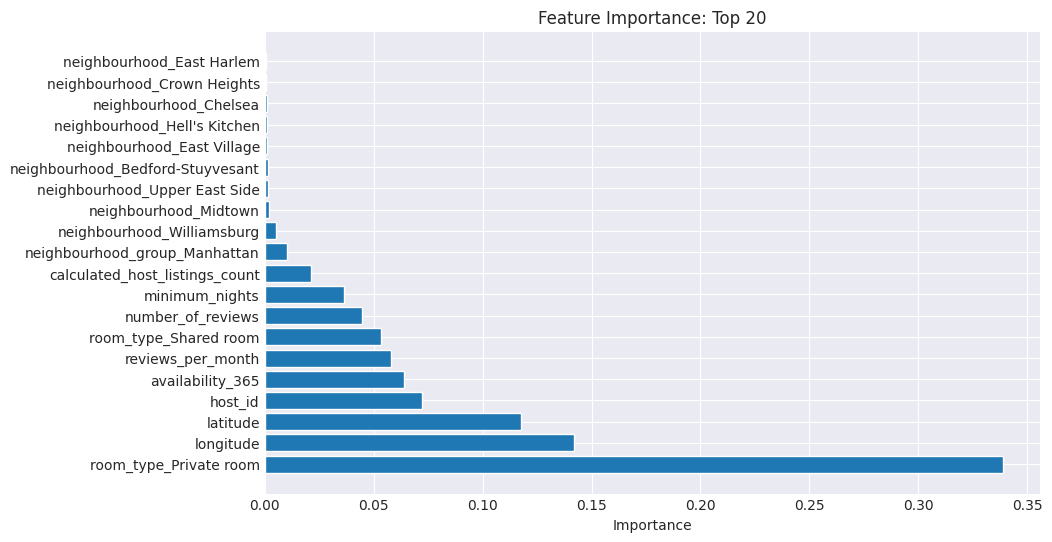

In [ ]:
# select our features (by dropping the un-needed columns) and select our target as price
X = df_training.drop(columns=['price', 'id', 'name', 'host_name', 'last_review', 'last_review_month'])
y = df_training['price']

model = RandomForestRegressor(n_estimators=100, random_state=37)
model.fit(X, y)

importances = model.feature_importances_

df_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# sort by importance
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

df_feature_importance_t20 = df_feature_importance.head(20)

print(df_feature_importance_t20)

plt.figure(figsize=(10, 6))
plt.barh(df_feature_importance_t20['Feature'], df_feature_importance_t20['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance: Top 20')
plt.show()

#### Predict prices

In [ ]:
# drop the same columns for our prediction set too
df_predict_dropped = df_predict.drop(columns=['price', 'id', 'name', 'host_name', 'last_review', 'last_review_month'])

# make predictions on unreviewed data
predictions = model.predict(df_predict_dropped)

# incorporate the predictions into our original prediction dataset
df_revised = df_predict.copy()
df_revised['predicted price'] = predictions

df_revised[['id', 'name','price','predicted price']].head(15)

,id,name,price,predicted price
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,150,137.86
19,7750,Huge 2 BR Upper East Cental Park,190,190.35
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,80,124.00
36,11452,Clean and Quiet in Brooklyn,35,77.85
38,11943,Country space in the city,150,106.78
193,51438,1 Bedroom in 2 Bdrm Apt- Upper East,130,119.67
204,54466,Beautiful Uptown Manhattan apartmnt,200,107.17
260,63588,LL3,90,89.78
265,63913,"HOSTING YOUR SUNNY, SPACIOUS NYC ROOM",75,86.22
267,64015,Prime East Village 1 Bedroom,200,151.45


#### Impact on pricing

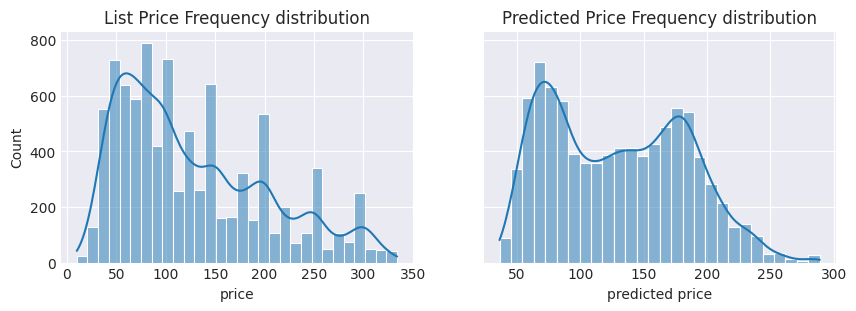

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

sns.histplot(data=df_revised, x='price', kde=True, ax=axes[0,]).set_title('List Price Frequency distribution')
sns.histplot(data=df_revised, x='predicted price', kde=True, ax=axes[1,]).set_title('Predicted Price Frequency distribution')

# remove labels
plt.gca().spines[['top', 'right',]].set_visible(False)

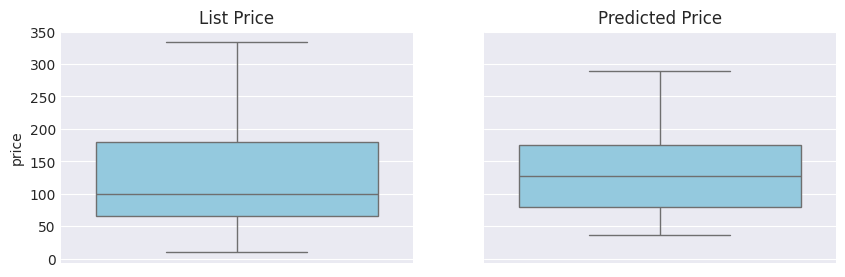

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

bp_price = sns.boxplot(data=df_revised, y='price', ax=axes[0,], fliersize=1, color='skyblue').set_title('List Price')
bp_predicted = sns.boxplot(data=df_revised, y='predicted price', ax=axes[1,], fliersize=1, color='skyblue').set_title('Predicted Price')

### KMeans Clustering on Price

In [ ]:
features = df_clean[['price']]

# standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# create kmeans model/object
kmeans = KMeans(
    init="random",
    n_clusters=20,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(features_scaled)
labels = kmeans.labels_
df_clean['cluster'] = labels

_clusters = df_clean.groupby('cluster')['price'].describe() #.count()

# fix the clusters to reflect the sort
_clusters = _clusters.sort_values(by=['mean'])
_clusters['cluster'] = range(1, len(_clusters) + 1)

#### Cluster Output

In [ ]:
print(_clusters)

          count        mean       std    min    25%    50%    75%    max  \
cluster                                                                    
16        776.0   27.400773  4.676690   10.0   25.0   29.0   30.0   32.0   
4        2417.0   38.310302  2.748515   33.0   35.0   39.0   40.0   43.0   
6        3814.0   48.516780  2.606173   44.0   45.0   50.0   50.0   54.0   
11       4627.0   60.212665  3.583563   55.0   58.0   60.0   65.0   65.0   
1        3602.0   71.754858  2.834142   66.0   70.0   70.0   75.0   75.0   
12       1973.0   79.547897  1.151928   76.0   79.0   80.0   80.0   82.0   
3        1177.0   85.037383  0.791298   83.0   85.0   85.0   85.0   87.0   
2        1746.0   90.024628  1.263084   88.0   89.0   90.0   90.0   94.0   
17       4371.0   99.437886  2.708825   95.0   99.0  100.0  100.0  107.0   
0        3103.0  115.561392  4.463407  108.0  110.0  115.0  120.0  122.0   
15       2746.0  128.817189  4.015282  123.0  125.0  129.0  130.0  138.0   
5        370

####Cluster Plot

<Axes: xlabel='cluster', ylabel='mean'>

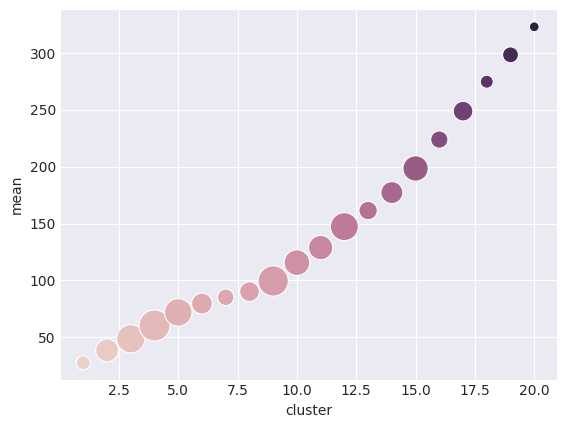

In [ ]:
sns.scatterplot(
    data=_clusters,
    x="cluster",
    y="mean",
    size="count",
    hue="mean",
    alpha=0.99,
    sizes=(50, 500),
    legend=False
)

####Cluster interpretation: Number of Reviews per Price Range

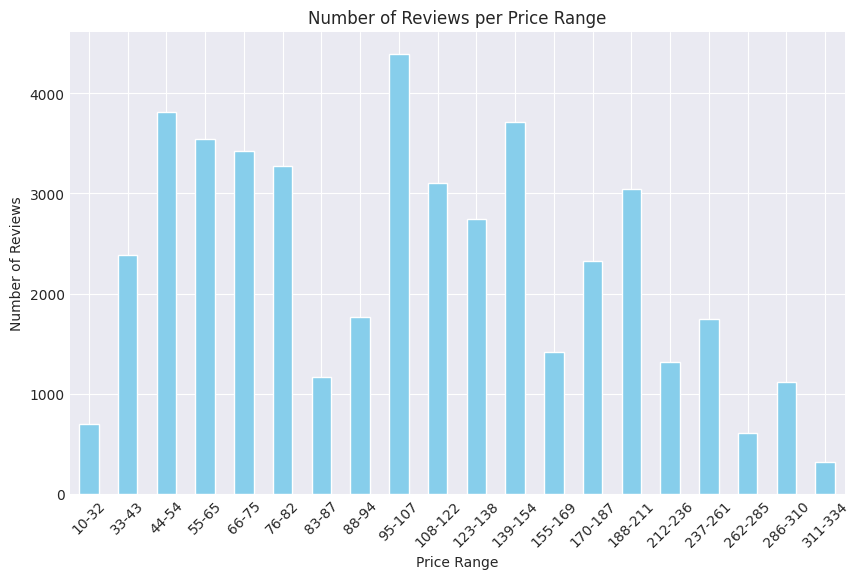

In [ ]:
# define bins based on the max values per cluster
bins = list(_clusters['max'].values)
bins.insert(0,min(_clusters['min'].values))

#generate bin labels - TODO rewrite, the comprehension is too complicated
labels = [f"{int(bins[i]+1) if i > 0 else int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins) - 1)]

df_clean['price_range'] = pd.cut(df_clean['price'], bins=bins, labels=labels, right=False)

# by numeber of reviews aand unique host id's
price_range_reviews = df_clean.groupby('price_range',observed=True).size()
price_range_hosts = df_clean.groupby('price_range',observed=True)['host_id'].nunique()

# bar plot showing average number of reviews by price range
price_range_reviews.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Reviews per Price Range')
plt.ylabel('Number of Reviews')
plt.xlabel('Price Range')
plt.xticks(rotation=45)

# hide graph info
plt.gca().spines[['top', 'right',]].set_visible(False)

**Observations:**

Several price ranges have less reviews than other ranges.

**Assumption:**

A higher average number of reviews could suggest that accommodation in a specific price range attract more customers.

 # TASK 3 (Analytical report)
In this task, you are expected to prepare a 1000 word analytical report, which can easily be interpreted by the executive board members of the Airbnb. There is no fixed specification for this report but in general, it must contain an adequate number of visualisation charts/graphs with a lucid description.

Please note: You are required to submit your Python code as an appendix for this assessment. Other appendices should not be used to extend the core report as reports should stand alone, complete, and concise, without the appendices. They should only be used if required, and only for supplementary and/ or supporting information. One key part of the exercises in this module is the need to be to be able to express ideas succinctly, concisely and with necessary brevity.